In [2]:
from skimage.color import rgb2hed, hed2rgb, rgb2hsv, rgb2lab, gray2rgb, hsv2rgb, rgb2gray
import os
import sys
import random
import warnings
import cv2
import numpy as np
import imageio
from PIL import Image

# import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from random import choice  # Import the choice function from the random module
from itertools import chain
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from skimage.morphology import disk
from skimage.filters import median
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.activations import *

from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.initializers import Constant
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *
from tensorflow.keras import *
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.initializers import *
from tensorflow.keras.layers import Input, Conv2D, Activation, Add, Lambda, Multiply

In [3]:
import tensorflow as tf
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import *
import os
import numpy as np
import cv2
from sklearn.preprocessing import MinMaxScaler
from skimage.color import rgb2hed, hed2rgb, rgb2hsv, rgb2lab, gray2rgb, hsv2rgb, rgb2gray
import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.backend import *

from tensorflow.keras.losses import binary_crossentropy


def f1_score1(y_true,y_pred):
    smooth=1
    y_true_f = flatten(y_true)
    y_pred_f = flatten(y_pred)
    intersection = sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (sum(y_true_f) + sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    smooth=1
    y_true_f = flatten(y_true)
    y_pred_f = flatten(y_pred)
    y_true_f = cast(y_true_f, dtype='float32')
    y_pred_f = cast(y_pred_f, dtype='float32')
    intersection = sum(y_true_f * y_pred_f)
    return 1-(2. * intersection + smooth) / (sum(y_true_f) + sum(y_pred_f) + smooth)

def jaccard_loss(y_true, y_pred, smooth=100):
        intersection = sum(abs(y_true * y_pred), axis=-1)
        sum_ = sum(abs(y_true) + abs(y_pred), axis=-1)
        jac = (intersection + smooth) / (sum_ - intersection + smooth)
        return (1 - jac) * smooth

def loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    def dice_coef_loss(y_true, y_pred):
        return dice_loss(y_true, y_pred)

    def jaccard_distance_loss(y_true, y_pred, smooth=100):
        intersection = sum(abs(y_true * y_pred), axis=-1)
        sum_ = sum(abs(y_true) + abs(y_pred), axis=-1)
        jac = (intersection + smooth) / (sum_ - intersection + smooth)
        return (1 - jac) * smooth

    return (jaccard_distance_loss(y_true, y_pred) * dice_coef_loss(y_true, y_pred))/(jaccard_distance_loss(y_true, y_pred) + dice_coef_loss(y_true, y_pred))

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_dice_jaccard_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred) + jaccard_loss(y_true, y_pred)

def dice_jaccard_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + jaccard_loss(y_true, y_pred)

def jaccard(y_true, y_pred, smooth=100):
    intersection = tf.reduce_sum(y_true * y_pred)
    sum_ = tf.reduce_sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac * smooth


def f1_score(y_true, y_pred):
    im1 = np.asarray(y_true).astype(np.bool)
    im2 = np.asarray(y_pred).astype(np.bool)
    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")
    intersection = np.logical_and(im1, im2)
    return 2. * intersection.sum() / (im1.sum() + im2.sum())


def IOU_Loss(y_true, y_pred):
    answ = tf.keras.metrics.MeanIoU(2, name=None, dtype=None)
    answ.update_state(y_true, y_pred)
    return answ.result().numpy()


def Precision(y_true, y_pred):
    answ = tf.keras.metrics.Precision()
    answ.update_state(y_true, y_pred)
    return answ.result().numpy()


def Recall(y_true, y_pred):
    answ = tf.keras.metrics.Recall()
    answ.update_state(y_true, y_pred)
    return answ.result().numpy()

import numpy as np


def jaccard_index(seg_mask, gt_mask):
    intersection = np.sum(np.logical_and(seg_mask, gt_mask))
    union = np.sum(np.logical_or(seg_mask, gt_mask))
    jaccard = intersection / union if union > 0 else 0.0
    return jaccard

def aggregated_jaccard_index(seg_masks, gt_masks):
    num_objects = len(seg_masks)
    ajis = []

    for i in range(num_objects):
        jis = [iou(seg_masks[i], gt_mask) for gt_mask in gt_masks]
        ajis.append(max(jis))

    aji = np.mean(ajis)
    return aji


def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    dice = (2.0 * intersection) / (union + 1e-8)  # Adding a small epsilon to avoid division by zero
    return dice * 100  # Convert to percentage

def iou(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(np.maximum(y_true, y_pred))
    iou = (intersection + 1e-8) / (union + 1e-8)  # Adding a small epsilon to avoid division by zero
    return iou * 100  # Convert to percentage

def precision(y_true, y_pred):
    true_positive = np.sum(y_true * y_pred)
    false_positive = np.sum(np.clip(y_pred - y_true, 0, 1))  # Calculating false positives
    precision = (true_positive + 1e-8) / (true_positive + false_positive + 1e-8)  # Adding a small epsilon to avoid division by zero
    return precision * 100  # Convert to percentage

def recall(y_true, y_pred):
    true_positive = np.sum(y_true * y_pred)
    false_negative = np.sum(np.clip(y_true - y_pred, 0, 1))  # Calculating false negatives
    recall = (true_positive + 1e-8) / (true_positive + false_negative + 1e-8)  # Adding a small epsilon to avoid division by zero
    return recall * 100  # Convert to percentage

def specificity(y_true, y_pred):
    true_negative = np.sum(np.clip((1 - y_true) * (1 - y_pred), 0, 1))
    false_positive = np.sum(np.clip(y_pred - y_true, 0, 1))  # Calculating false positives
    specificity = (true_negative + 1e-8) / (true_negative + false_positive + 1e-8)  # Adding a small epsilon to avoid division by zero
    return specificity * 100  # Convert to percentage

def accuracy(y_true, y_pred):
    correct_pixels = np.sum(y_true == y_pred)
    total_pixels = y_true.size
    accuracy = (correct_pixels / total_pixels) * 100
    return accuracy

import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.backend import *

from tensorflow.keras.losses import binary_crossentropy

  ##### Metrices & Loss #####
#------------- Metrice-------------
def f1_score1(y_true,y_pred):
    smooth=1
    y_true_f = flatten(y_true)
    y_pred_f = flatten(y_pred)
    intersection = sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (sum(y_true_f) + sum(y_pred_f) + smooth)
#----------------------------------
# -------------Loss----------------
def dice_loss(y_true, y_pred):
    smooth=1
    y_true_f = flatten(y_true)
    y_pred_f = flatten(y_pred)
    y_true_f = cast(y_true_f, dtype='float32')
    y_pred_f = cast(y_pred_f, dtype='float32')
    intersection = sum(y_true_f * y_pred_f)
    return 1-(2. * intersection + smooth) / (sum(y_true_f) + sum(y_pred_f) + smooth)

def jaccard_loss(y_true, y_pred, smooth=100):
        intersection = sum(abs(y_true * y_pred), axis=-1)
        sum_ = sum(abs(y_true) + abs(y_pred), axis=-1)
        jac = (intersection + smooth) / (sum_ - intersection + smooth)
        return (1 - jac) * smooth

def loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    def dice_coef_loss(y_true, y_pred):
        return dice_loss(y_true, y_pred)

    def jaccard_distance_loss(y_true, y_pred, smooth=100):
        intersection = sum(abs(y_true * y_pred), axis=-1)
        sum_ = sum(abs(y_true) + abs(y_pred), axis=-1)
        jac = (intersection + smooth) / (sum_ - intersection + smooth)
        return (1 - jac) * smooth

    return (jaccard_distance_loss(y_true, y_pred) * dice_coef_loss(y_true, y_pred))/(jaccard_distance_loss(y_true, y_pred) + dice_coef_loss(y_true, y_pred))

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_dice_jaccard_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred) + jaccard_loss(y_true, y_pred)

def dice_jaccard_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + jaccard_loss(y_true, y_pred)
#-----------------------------------
def calculate_fpr(false_positives, true_negatives):
    """
    Calculate the false positive rate (FPR) given the number of false positives (FP)
    and the number of true negatives (TN).

    Args:
    false_positives (int): Number of false positive cases.
    true_negatives (int): Number of true negative cases.

    Returns:
    float: False positive rate (FPR).
    """
    total_negative = false_positives + true_negatives
    if total_negative == 0:
        return 0  # Handling division by zero
    fpr = false_positives / total_negative
    return fpr

def calculate_fnr(false_negatives, true_positives):
    """
    Calculate the false negative rate (FNR) given the number of false negatives (FN)
    and the number of true positives (TP).

    Args:
    false_negatives (int): Number of false negative cases.
    true_positives (int): Number of true positive cases.

    Returns:
    float: False negative rate (FNR).
    """
    total_positive = false_negatives + true_positives
    if total_positive == 0:
        return 0  # Handling division by zero
    fnr = false_negatives / total_positive
    return fnr

In [4]:
import os
import cv2
import numpy as np

def load_images_and_masks(data_path):
    images = []
    masks = []
    
    image_files = []
    mask_files = []

    # Gather all image and mask files
    for root, dirs, files in os.walk(data_path):
        if 'images' in root:
            image_files.extend([os.path.join(root, f) for f in files if f.endswith('.png')])
        if 'sem_masks' in root:
            mask_files.extend([os.path.join(root, f) for f in files if f.endswith('.png')])
    
    print(f"Total image files found: {len(image_files)}")
    print(f"Total mask files found: {len(mask_files)}")

    # Sort the files to ensure the order matches
    image_files.sort()
    mask_files.sort()
    
    # Ensure the number of images matches the number of masks
    if len(image_files) != len(mask_files):
        print("Number of images and masks do not match!")
        return np.array(images), np.array(masks)
    
    # Load and process the images and masks
    for img_file, mask_file in zip(image_files, mask_files):
        try:
            # Read the images
            image = cv2.imread(img_file)
            mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
            
            if image is None:
                print(f"Failed to load image: {img_file}")
                continue
            if mask is None:
                print(f"Failed to load mask: {mask_file}")
                continue
            
            # Normalize images and masks
            image = image.astype(np.float32) / 255.0
            mask = mask.astype(np.float32) / 255.0
            
            # Threshold masks
            mask[mask > 0.0] = 1.0
            
            images.append(image)
            masks.append(mask)
            
        except Exception as e:
            print(f"Error processing files {img_file} and {mask_file}: {e}")
    
    return np.array(images), np.array(masks)

# Update the path to your dataset directory
data_path = 'C:/Users/HP/OneDrive/Desktop/Rashika/Paper_1/dataset_pannuke2/'
train_images_hc, train_masks_hc = load_images_and_masks(data_path)

print(f"Loaded {len(train_images_hc)} images and {len(train_masks_hc)} masks")


Total image files found: 6103
Total mask files found: 6103
Loaded 6103 images and 6103 masks


In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(train_images_hc, train_masks_hc,
                                        test_size=0.2, random_state=15)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid,
                                        test_size=0.2, random_state=15)
# X_train, X_valid, y_train, y_valid = train_test_split(train_images_hc, train_masks_hc,
#                                         test_size=0.2, random_state=5)
# X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid,
#                                         test_size=0.2, random_state=5)
# X_train, X_valid, y_train, y_valid = train_test_split(train_images_hc, train_masks_hc,
#                                         test_size=0.2, random_state=10)
# X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid,
#                                         test_size=0.2, random_state=10)
# X_train, X_valid, y_train, y_valid = train_test_split(train_images_hc, train_masks_hc,
#                                         test_size=0.2, random_state=15)
# X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid,
#                                         test_size=0.2, random_state=15)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 8)  224         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 8)  32         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

INFO:tensorflow:Assets written to: unet_pannuke5\assets


INFO:tensorflow:Assets written to: unet_pannuke5\assets


8/8 [==============================] - 5s 292ms/step
Dice Coefficient: 79.94%
IoU (Jaccard Index): 66.59%
Precision: 69.56%
Recall: 93.97%
Specificity: 89.82%
Accuracy: 90.65%


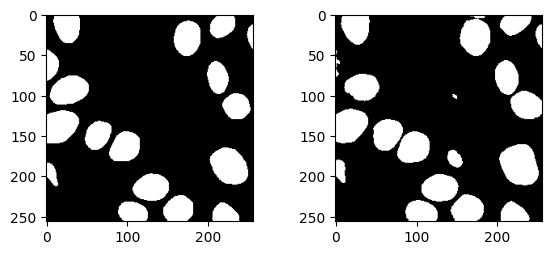

In [5]:

def dice_loss(y_true, y_pred):
    smooth = 1
    y_true_f = flatten(y_true)
    y_pred_f = flatten(y_pred)
    y_true_f = cast(y_true_f, dtype='float32')
    y_pred_f = cast(y_pred_f, dtype='float32')
    intersection = sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (sum(y_true_f) + sum(y_pred_f) + smooth)


def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


def bce_loss(y_true, y_pred):
    return tf.squeeze(binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred), axis=0)


def loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    def dice_coef_loss(y_true, y_pred):
        return dice_loss(y_true, y_pred)

    def jaccard_distance_loss(y_true, y_pred, smooth=100):
        intersection = sum(abs(y_true * y_pred), axis=-1)
        sum_ = sum(abs(y_true) + abs(y_pred), axis=-1)
        jac = (intersection + smooth) / (sum_ - intersection + smooth)
        return (1 - jac) * smooth

    return (jaccard_distance_loss(y_true, y_pred) * dice_coef_loss(y_true, y_pred)) / (
                jaccard_distance_loss(y_true, y_pred) + dice_coef_loss(y_true, y_pred))


from tensorflow.keras.layers import *
from tensorflow.keras import *
from tensorflow.keras.initializers import *
from tensorflow.keras.activations import *
# from loss import *
# from metrics import *


def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = BatchNormalization(epsilon=1e-3, beta_initializer=Constant(0.0), gamma_initializer=Constant(1.0), momentum=0.5)(c)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c = BatchNormalization(epsilon=1e-3, beta_initializer=Constant(0.0), gamma_initializer=Constant(1.0), momentum=0.5)(c)
    p = MaxPooling2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = UpSampling2D((2, 2))(x)
    concat = Concatenate()([us, skip])
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = BatchNormalization(epsilon=1e-3, beta_initializer=Constant(0.0), gamma_initializer=Constant(1.0), momentum=0.5)(c)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c = BatchNormalization(epsilon=1e-3, beta_initializer=Constant(0.0), gamma_initializer=Constant(1.0), momentum=0.5)(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = BatchNormalization(epsilon=1e-3, beta_initializer=Constant(0.0), gamma_initializer=Constant(1.0), momentum=0.5)(c)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c = BatchNormalization(epsilon=1e-3, beta_initializer=Constant(0.0), gamma_initializer=Constant(1.0), momentum=0.5)(c)
    return c

def UNet():
    f = [8, 16, 32, 64, 128, 256, 512]
    inputs = Input((256, 256, 3))

    p0 = inputs
    c1, p1 = down_block(p0, f[0])  # 128 -> 64
    c2, p2 = down_block(p1, f[1])  # 64 -> 32
    c3, p3 = down_block(p2, f[2])  # 32 -> 16
    c4, p4 = down_block(p3, f[3])  # 16 -> 8

    bn = bottleneck(p4, f[4])

    u1 = up_block(bn, c4, f[3])  # 8 -> 16
    u2 = up_block(u1, c3, f[2])  # 16 -> 32
    u3 = up_block(u2, c2, f[1])  # 32 -> 64
    u4 = up_block(u3, c1, f[0])  # 64 -> 128

    outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = Model(inputs, outputs)
    return model


dice_values = []
iou_values = []
precision_values = []
recall_values = []
specificity_values = []
accuracy_values = []
fpr=[]
fnr=[]

initial_learning_rate = 0.001
decay_rate = 0.99
decay_steps = 10  # Decay the learning rate after every 10 epochs

# Define the learning rate schedule
def learning_rate_scheduler(epoch):
    return initial_learning_rate * decay_rate ** (epoch // decay_steps)

# Create an Adam optimizer with the specified initial learning rate
adam = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

# model.compile(optimizer=optimizers.Adam(lr=0.001), loss=dice_loss, metrics=['accuracy'], run_eagerly=True)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(8)
valid_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(8)
model.summary()

model = UNet()
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])


# Use the Dataset in model training
model.fit(
   train_dataset,
   epochs=50,
   validation_data=valid_dataset,
)

# Save the trained model
model.save('unet_pannuke5')

predicted = model.predict(X_test)
threshold = 0.2
y_test1 = (y_test > threshold).astype(int)
predicted1 = (predicted > threshold).astype(int)
predicted1 = np.squeeze(predicted1, axis=-1)
# Calculate metrics
dice = dice_coefficient(y_test1, predicted1)
iou_value = iou(y_test1, predicted1)
precision_value = precision(y_test1, predicted1)
recall_value = recall(y_test1, predicted1)
specificity_value = specificity(y_test1, predicted1)
accuracy_value = accuracy(y_test1, predicted1)
# Print the results
print(f"Dice Coefficient: {dice:.2f}%")
print(f"IoU (Jaccard Index): {iou_value:.2f}%")
print(f"Precision: {precision_value:.2f}%")
print(f"Recall: {recall_value:.2f}%")
print(f"Specificity: {specificity_value:.2f}%")
print(f"Accuracy: {accuracy_value:.2f}%")
# print(f"AJI: {aji:.2f}%")

fig=plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax=fig.add_subplot(1,2,1)
ax.imshow(y_test[2],cmap="gray")
ax=fig.add_subplot(1,2,2)
ax.imshow(predicted1[2],cmap="gray")

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization
from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import Model

def attention_block_2d(x, g, inter_channel):
    # theta_x(?,g_height,g_width,inter_channel)

    theta_x = Conv2D(filters=inter_channel, kernel_size=(1, 1), strides=(1, 1),padding='same')(x)

    # phi_g(?,g_height,g_width,inter_channel)

    phi_g = Conv2D(filters=inter_channel, kernel_size=(1, 1), strides=(1, 1),padding='same')(g)

    # f(?,g_height,g_width,inter_channel)

    f = Activation('relu')(add([theta_x, phi_g]))

    # psi_f(?,g_height,g_width,1)

    psi_f = Conv2D(filters=1, kernel_size=(1, 1), strides=(1, 1),padding='same')(f)

    rate = Activation('sigmoid')(psi_f)
    # rate(?,x_height,x_width)

    # att_x(?,x_height,x_width,x_channel)

    att_x = multiply([x, rate])

    return att_x

def attention_up_and_concate(down_layer, layer):

    in_channel = down_layer.get_shape().as_list()[3]

    # up = Conv2DTranspose(out_channel, [2, 2], strides=[2, 2])(down_layer)
    up = UpSampling2D(size=(2, 2),interpolation = 'nearest')(down_layer)

    layer = attention_block_2d(x=layer, g=up, inter_channel=in_channel // 4)

    concate = concatenate([up, layer], axis=3)

    return concate
def down_block(x, filt):
    cn = Conv2D(filters = filt, kernel_size=(3, 3), strides=1, padding='same', activation='relu',
               use_bias=True, kernel_initializer='glorot_normal')(x)
    d1 =  Dropout(0.2)(cn)
    cn1 = Conv2D(filters = filt,  kernel_size=(3, 3), strides=1, padding='same', activation='relu',
               use_bias=True, kernel_initializer='glorot_normal')(d1)
    p = MaxPooling2D((2, 2), strides=(2, 2),padding='same')(cn1)
    return cn1, p

def up_block(x, skip, filt):
    concat = attention_up_and_concate(x, skip)
    cnn = Conv2D(filters=filt, kernel_size=(3, 3), strides=1, padding='same', activation='relu',
               use_bias=True, kernel_initializer='glorot_normal')(concat)
    d2 =  Dropout(0.2)(cnn)
    cnn1 = Conv2D(filters=filt, kernel_size=(3, 3), strides=1, padding='same', activation='relu',
               use_bias=True, kernel_initializer='glorot_normal')(d2)
    return cnn1

def bottleneck(x, filt):
    cnt = Conv2D(filters=filt, kernel_size=(3, 3), strides=1, padding='same', activation='relu',
               use_bias=True, kernel_initializer='glorot_normal')(x)
    d3 = Dropout(0.2)(cnt)
    cnt1 = Conv2D(filters=filt, kernel_size=(3, 3), strides=1, padding='same', activation='relu',
               use_bias=True, kernel_initializer='glorot_normal')(d3)
    return cnt1

def att_UNet():
    f = [32, 64, 128, 256, 512, 1024]
    #inputs = keras.layers.Input((image_size, image_size, 3))
    inputs= Input((256,256,3))

    # p0 = inputs
    c1, p1 = down_block(inputs, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    pd1 = Dropout(0.2)(p4)
    bn = bottleneck(pd1, f[4])
    pd2 = Dropout(0.2)(bn)
    u1 = up_block(pd2, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128

    outputs = Conv2D(filters=1, kernel_size=(1,1), strides=(1,1), padding='same', activation='sigmoid')(u4)
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

def CropAndMerge(Input1, Input2, name="bridge"):
    """
    Crop input1 so that it matches input2 and then
    return the concatenation of both channels.
    """
    Size1_x = (Input1).shape[1]
    Size2_x = (Input2).shape[1]

    Size1_y = (Input1).shape[2]
    Size2_y = (Input2).shape[2]

    diff_x = tf.divide(tf.subtract(Size1_x, Size2_x), 2)
    diff_y = tf.divide(tf.subtract(Size1_y, Size2_y), 2)
    diff_x = tf.cast(diff_x, tf.int32)
    Size2_x = tf.cast(Size2_x, tf.int32)
    diff_y = tf.cast(diff_y, tf.int32)
    Size2_y = tf.cast(Size2_y, tf.int32)
    crop = tf.slice(Input1, [0, diff_x, diff_y, 0], [-1, Size2_x, Size2_y, -1])
    concat = tf.concat([crop, Input2], axis=3)

    return concat


def bn_conv_relu(input, filters):
    x = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', use_bias=True,
               kernel_initializer='glorot_normal', bias_initializer=Constant(0.1))(input)
    x = BatchNormalization(epsilon=1e-3, beta_initializer=Constant(0.0), gamma_initializer=Constant(1.0), momentum=0.5)(
        x)
    x = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', use_bias=True,
               kernel_initializer='glorot_normal', bias_initializer=Constant(0.1))(x)
    x = BatchNormalization(epsilon=1e-3, beta_initializer=Constant(0.0), gamma_initializer=Constant(1.0), momentum=0.5)(
        x)

    return x


def bn_upconv_relu(input, filters, conc):
    x = Conv2DTranspose(filters=filters, kernel_size=(2, 2), activation='relu', strides=(2, 2), padding='same',
                        kernel_initializer='glorot_normal', bias_initializer=Constant(0.1), use_bias=True)(input)
    x = CropAndMerge(Input1=x, Input2=conc, name='bridge')

    return x


def dist(

        num_classes=1,
        output_activation='sigmoid'):
    inputs = Input((256, 256, 3))

    filters = [32, 64, 128, 256, 512]

    # for l in range(num_layers):
    x_conv1 = bn_conv_relu(inputs, filters[0])
    x_pool1 = MaxPooling2D((2, 2), strides=(2, 2), padding="same")(x_conv1)
    x_conv2 = bn_conv_relu(x_pool1, filters[1])
    x_pool2 = MaxPooling2D((2, 2), strides=(2, 2), padding="same")(x_conv2)
    x_conv3 = bn_conv_relu(x_pool2, filters[2])
    x_pool3 = MaxPooling2D((2, 2), strides=(2, 2), padding="same")(x_conv3)
    x_conv4 = bn_conv_relu(x_pool3, filters[3])
    x_pool4 = MaxPooling2D((2, 2), strides=(2, 2), padding="same")(x_conv4)
    x_conv5 = bn_conv_relu(x_pool4, filters[4])

    # upsampling in the form of convtranspose

    x_tconv5 = bn_upconv_relu(x_conv5, filters[3], x_conv4)
    u_conv4 = bn_conv_relu(x_tconv5, filters[3])
    x_tconv4 = bn_upconv_relu(u_conv4, filters[2], x_conv3)
    u_conv3 = bn_conv_relu(x_tconv4, filters[2])
    x_tconv3 = bn_upconv_relu(u_conv3, filters[1], x_conv2)
    u_conv2 = bn_conv_relu(x_tconv3, filters[1])
    x_tconv2 = bn_upconv_relu(u_conv2, filters[0], x_conv1)
    u_conv1 = bn_conv_relu(x_tconv2, filters[0])

    outputs = Conv2D(num_classes, kernel_size=(1, 1), strides=(1, 1), activation=output_activation, padding='same')(
        u_conv1)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

dice_values = []
iou_values = []
precision_values = []
recall_values = []
specificity_values = []
accuracy_values = []
fpr=[]
fnr=[]

initial_learning_rate = 0.001
decay_rate = 0.99
decay_steps = 10  # Decay the learning rate after every 10 epochs

# Define the learning rate schedule
def learning_rate_scheduler(epoch):
    return initial_learning_rate * decay_rate ** (epoch // decay_steps)

# Create an Adam optimizer with the specified initial learning rate
adam = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

# model.compile(optimizer=optimizers.Adam(lr=0.001), loss=dice_loss, metrics=['accuracy'], run_eagerly=True)
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(8)
# valid_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(8)
# model.summary()

model = dist()
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])


# Use the Dataset in model training
model.fit(
   train_dataset,
   epochs=50,
   validation_data=valid_dataset,
)

# Save the trained model
model.save('attention_pannuke5')

predicted = model.predict(X_test)
threshold = 0.2
y_test1 = (y_test > threshold).astype(int)
predicted1 = (predicted > threshold).astype(int)
predicted1 = np.squeeze(predicted1, axis=-1)
# Calculate metrics
dice = dice_coefficient(y_test1, predicted1)
iou_value = iou(y_test1, predicted1)
precision_value = precision(y_test1, predicted1)
recall_value = recall(y_test1, predicted1)
specificity_value = specificity(y_test1, predicted1)
accuracy_value = accuracy(y_test1, predicted1)
# Print the results
print(f"Dice Coefficient: {dice:.2f}%")
print(f"IoU (Jaccard Index): {iou_value:.2f}%")
print(f"Precision: {precision_value:.2f}%")
print(f"Recall: {recall_value:.2f}%")
print(f"Specificity: {specificity_value:.2f}%")
print(f"Accuracy: {accuracy_value:.2f}%")
# print(f"AJI: {aji:.2f}%")

fig=plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax=fig.add_subplot(1,2,1)
ax.imshow(y_test[2],cmap="gray")
ax=fig.add_subplot(1,2,2)
ax.imshow(predicted1[2],cmap="gray")

Epoch 1/50


ResourceExhaustedError: Graph execution error:

Detected at node 'model_1/conv2d_transpose_2/conv2d_transpose' defined at (most recent call last):
    File "C:\Users\HP\anaconda3\envs\tensorflowgpu\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\HP\anaconda3\envs\tensorflowgpu\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\HP\anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\HP\anaconda3\envs\tensorflowgpu\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\HP\anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "C:\Users\HP\anaconda3\envs\tensorflowgpu\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\HP\anaconda3\envs\tensorflowgpu\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\HP\anaconda3\envs\tensorflowgpu\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "C:\Users\HP\anaconda3\envs\tensorflowgpu\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\HP\anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "C:\Users\HP\anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "C:\Users\HP\anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "C:\Users\HP\anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "C:\Users\HP\anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\HP\anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\HP\anaconda3\envs\tensorflowgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "C:\Users\HP\anaconda3\envs\tensorflowgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "C:\Users\HP\anaconda3\envs\tensorflowgpu\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\HP\anaconda3\envs\tensorflowgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\HP\anaconda3\envs\tensorflowgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\HP\anaconda3\envs\tensorflowgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\HP\AppData\Local\Temp\ipykernel_25240\4274699072.py", line 202, in <module>
      model.fit(
    File "C:\Users\HP\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\HP\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\HP\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\HP\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\HP\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\HP\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\HP\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\HP\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\HP\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\HP\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\HP\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\HP\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\HP\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\HP\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\HP\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\HP\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\HP\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\layers\convolutional\conv2d_transpose.py", line 296, in call
      outputs = backend.conv2d_transpose(
    File "C:\Users\HP\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\backend.py", line 6119, in conv2d_transpose
      x = tf.compat.v1.nn.conv2d_transpose(
Node: 'model_1/conv2d_transpose_2/conv2d_transpose'
OOM when allocating tensor with shape[8,64,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_1/conv2d_transpose_2/conv2d_transpose}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_9900]

In [ ]:
# with tf.keras.utils.custom_object_scope({'dice_jaccard_loss': dice_jaccard_loss}):
#     model = load_model('proposed_pannuke')

# # predicted = model.predict(X_test)
# threshold = 0.5
# y_test1 = (y_test > threshold).astype(int)
# predicted1 = (predicted > threshold).astype(int)
# predicted1 = np.squeeze(predicted1, axis=-1)
# # Calculate metrics
# dice = dice_coefficient(y_test1, predicted1)
# iou_value = iou(y_test1, predicted1)
# precision_value = precision(y_test1, predicted1)
# recall_value = recall(y_test1, predicted1)
# specificity_value = specificity(y_test1, predicted1)
# accuracy_value = accuracy(y_test1, predicted1)
# # Print the results
# print(f"Dice Coefficient: {dice:.2f}%")
# print(f"IoU (Jaccard Index): {iou_value:.2f}%")
# print(f"Precision: {precision_value:.2f}%")
# print(f"Recall: {recall_value:.2f}%")
# print(f"Specificity: {specificity_value:.2f}%")
# print(f"Accuracy: {accuracy_value:.2f}%")
# # print(f"AJI: {aji:.2f}%")

# fig=plt.figure()

# fig.subplots_adjust(hspace=0.4, wspace=0.4)

# ax=fig.add_subplot(1,2,1)
# ax.imshow(y_test[2],cmap="gray")

# ax=fig.add_subplot(1,2,2)
# ax.imshow(predicted1[2],cmap="gray")

In [ ]:
# with tf.keras.utils.custom_object_scope({'loss': loss}):
#     model = load_model('dan_pannuke')
# predicted = model.predict(X_test)
# threshold = 0.8
# y_test1 = (y_test > threshold).astype(int)
# predicted1 = (predicted > threshold).astype(int)
# predicted1 = np.squeeze(predicted1, axis=-1)
# # Calculate metrics
# dice = dice_coefficient(y_test1, predicted1)
# iou_value = iou(y_test1, predicted1)
# precision_value = precision(y_test1, predicted1)
# recall_value = recall(y_test1, predicted1)
# specificity_value = specificity(y_test1, predicted1)
# accuracy_value = accuracy(y_test1, predicted1)
# # Print the results
# print(f"Dice Coefficient: {dice:.2f}%")
# print(f"IoU (Jaccard Index): {iou_value:.2f}%")
# print(f"Precision: {precision_value:.2f}%")
# print(f"Recall: {recall_value:.2f}%")
# print(f"Specificity: {specificity_value:.2f}%")
# print(f"Accuracy: {accuracy_value:.2f}%")
# # print(f"AJI: {aji:.2f}%")

# fig=plt.figure()

# fig.subplots_adjust(hspace=0.4, wspace=0.4)

# ax=fig.add_subplot(1,2,1)
# ax.imshow(y_test[2],cmap="gray")

# ax=fig.add_subplot(1,2,2)
# ax.imshow(predicted1[2],cmap="gray")